# Comparison between sklearn's and gensim's implementations of NMF

In [1]:
%load_ext line_profiler
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_documents
from gensim import matutils
from sklearn.decomposition.nmf import NMF as SklearnNmf
import sklearn.decomposition.nmf
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from matplotlib import pyplot as plt

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 20newsgroups

In [25]:
from gensim.parsing.preprocessing import preprocess_documents

documents = preprocess_documents(fetch_20newsgroups().data[:100])

In [26]:
from gensim.corpora import Dictionary

dictionary = Dictionary(documents)

2018-04-23 05:38:42,334 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-23 05:38:42,353 : INFO : built Dictionary(4357 unique tokens: ['addit', 'bodi', 'bricklin', 'brought', 'bumper']...) from 100 documents (total 14240 corpus positions)


In [27]:
corpus = [
    dictionary.doc2bow(document)
    for document
    in documents
]

bow_matrix = matutils.corpus2dense(corpus, len(dictionary), len(corpus))

## Sklearn NMF

In [28]:
%%time
# %%prun

sklearn_nmf = SklearnNmf(n_components=5, tol=1e-5, max_iter=int(1e9), random_state=42)

W = sklearn_nmf.fit_transform(bow_matrix)
H = sklearn_nmf.components_

CPU times: user 270 ms, sys: 340 ms, total: 610 ms
Wall time: 197 ms


In [29]:
# %lprun -f sklearn.decomposition.nmf._fit_coordinate_descent sklearn_nmf.fit_transform(bow_matrix)

In [30]:
np.linalg.norm(bow_matrix - W.dot(H), 'fro')

144.36518804676317

## Gensim NMF

In [31]:
%%time
# %%prun

np.random.seed(42)

gensim_nmf = GensimNmf(
    corpus,
    chunksize=len(corpus),
    num_topics=5,
    id2word=dictionary,
    lambda_=1000.,
    kappa=1.,
    normalize=False
)

2018-04-23 05:38:44,984 : INFO : Loss (no outliers): 172.38983686111413	Loss (with outliers): 172.38983686111413


CPU times: user 1.55 s, sys: 1.89 s, total: 3.44 s
Wall time: 961 ms


In [32]:
# %lprun -f GensimNmf._solveproj GensimNmf(corpus, chunksize=len(corpus), num_topics=5, id2word=dictionary, lambda_=1000., kappa=1.)

In [33]:
W = gensim_nmf.get_topics().T
H = np.hstack(gensim_nmf[bow] for bow in corpus)

In [34]:
np.linalg.norm(matutils.corpus2dense(corpus, len(dictionary), len(documents)) - W.dot(H), 'fro')

154.25266942061842

In [35]:
gensim_nmf.show_topics()

[(0,
  '0.243*"armenian" + 0.111*"russian" + 0.095*"peopl" + 0.071*"genocid" + 0.070*"turkish" + 0.070*"jew" + 0.067*"armi" + 0.061*"ottoman" + 0.059*"post" + 0.057*"turk"'),
 (1,
  '0.070*"year" + 0.051*"insur" + 0.046*"car" + 0.042*"edu" + 0.034*"rate" + 0.030*"live" + 0.029*"state" + 0.028*"subject" + 0.028*"line" + 0.024*"think"'),
 (2,
  '0.106*"orbit" + 0.071*"space" + 0.056*"launch" + 0.051*"mission" + 0.046*"probe" + 0.038*"shuttl" + 0.037*"option" + 0.035*"titan" + 0.034*"earth" + 0.028*"power"'),
 (3,
  '0.027*"reserv" + 0.022*"center" + 0.021*"close" + 0.018*"naval" + 0.017*"dai" + 0.016*"inform" + 0.014*"time" + 0.013*"includ" + 0.013*"marin" + 0.012*"corp"'),
 (4,
  '0.048*"scsi" + 0.039*"probe" + 0.029*"titan" + 0.029*"us" + 0.028*"earth" + 0.026*"observ" + 0.023*"edu" + 0.023*"launch" + 0.021*"atmospher" + 0.019*"satellit"')]

From the personal experience I can say that the higher number of passes and shuffle of the trainset significantly improves performance.

Then, of course, you should perform hyperparameter tuning.

# Image of stars
### (For the sake of visualization of performance on sparse trainset)

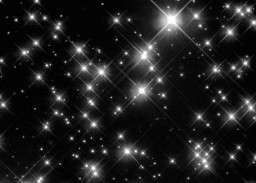

In [12]:
from PIL import Image
img = Image.open('stars_scaled.jpg').convert('L')
img

In [13]:
img_matrix = np.uint8(img.getdata()).reshape(img.size[::-1])
img_matrix.shape

(183, 256)

## Sklearn NMF

In [14]:
%%time

sklearn_nmf = SklearnNmf(n_components=10, tol=1e-5, max_iter=int(1e9))

W = sklearn_nmf.fit_transform(img_matrix)
H = sklearn_nmf.components_

CPU times: user 252 ms, sys: 252 ms, total: 504 ms
Wall time: 247 ms


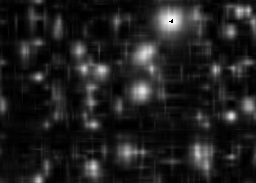

In [15]:
Image.fromarray(np.uint8(W.dot(H)), 'L')

## Gensim NMF

In [16]:
%%time

import itertools

np.random.seed(42)

img_corpus = matutils.Dense2Corpus(img_matrix[np.random.choice(img_matrix.shape[0], img_matrix.shape[0], replace=False)].T)

gensim_nmf = GensimNmf(
    img_corpus,
    chunksize=40,
    num_topics=10,
    passes=1,
    id2word={k: k for k in range(img_matrix.shape[1])},
    lambda_=1000.,
    kappa=1.,
    normalize=False
)

2018-04-23 04:48:55,768 : INFO : Loss (no outliers): 4649.176186445958	Loss (with outliers): 4649.176186445958
2018-04-23 04:48:56,545 : INFO : Loss (no outliers): 2545.831439439685	Loss (with outliers): 2545.831439439685
2018-04-23 04:48:56,860 : INFO : Loss (no outliers): 2157.622569525167	Loss (with outliers): 2157.622569525167
2018-04-23 04:48:57,051 : INFO : Loss (no outliers): 2111.146762974082	Loss (with outliers): 2111.146762974082
2018-04-23 04:48:57,170 : INFO : Loss (no outliers): 1428.3477896008337	Loss (with outliers): 1428.3477896008337


CPU times: user 1.6 s, sys: 116 ms, total: 1.72 s
Wall time: 1.57 s


In [17]:
W = gensim_nmf.get_topics().T
H = np.hstack(gensim_nmf[bow] for bow in matutils.Dense2Corpus(img_matrix.T))

### Reconstructed matrix:

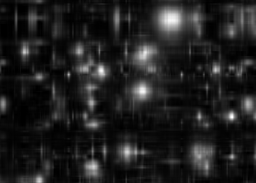

In [18]:
Image.fromarray(np.uint8(W.dot(H).T), 'L')